In [1]:
### set up the notebook
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from scipy.interpolate import griddata
import scipy.stats as stats
from skspatial.objects import Plane, Points
from skspatial.plotting import plot_3d

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=100) 

plt.rcParams.update({'font.size': 14})

In [2]:
def remove_outliers_IQR(data, limit):
    q1 = np.nanpercentile(data, 25)
    q3 = np.nanpercentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - limit * iqr
    upper_bound = q3 + limit * iqr
    # where data is outside bounds, replace with nan
    data_cp = data.copy()
    data_cp[(data_cp < lower_bound) | (data_cp > upper_bound)] = np.nan
    print('Removed %d / %d points' % (np.sum(np.isnan(data_cp)), len(data.flatten())))
    return data_cp

In [3]:
# load the buoy data
buoy = xr.open_dataset('GNSS_at_SWOT_times.nc')

# load the swot data
swot = xr.open_dataset('SWOT_products_at_buoys.nc')


In [4]:
# apply corrections to SWOT SSH to make it comparable to buoys (solid earth, SE of pole tide, ocean tidal loading)
# do not apply crossover height correction as we want to compute the fit to residuals)

h2 = 0.6207
k2 = 0.302
pole_factor = h2 / (1 + k2)

swot['ssh_comparison'] = swot.PGC_ssh_karin_2 - swot.PGC_solid_earth_tide - swot.PGC_load_tide_fes - swot.PGC_pole_tide * pole_factor
swot['ssh_comparison_PIB'] = swot.PIB_ssh_karin_2 - swot.PIB_solid_earth_tide - swot.PIB_load_tide_fes - swot.PIB_pole_tide * pole_factor

# apply quality flag, preserving points at buoy closest to the coast which would otherwise be discarded
swot['ssh_comparison'] = swot['ssh_comparison'].where(swot.PGC_ssh_karin_2_qual < 257)
swot['ssh_comparison_PIB'] = swot['ssh_comparison_PIB'].where(swot.PIB_ssh_karin_2_qual < 257)

# apply quality flag to buoy
buoy['ssh'] = buoy['ssh'].where(buoy.ssh_quality <2)

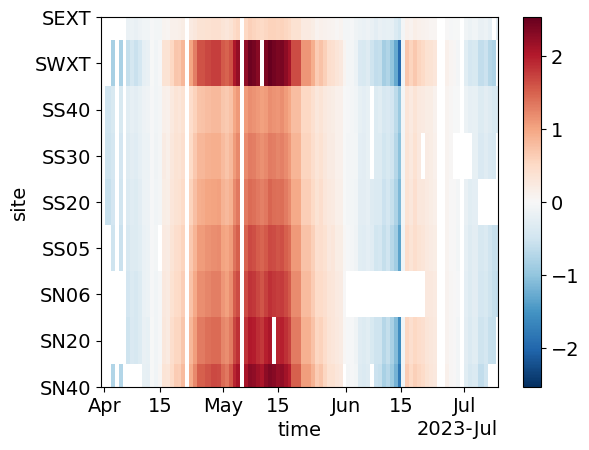

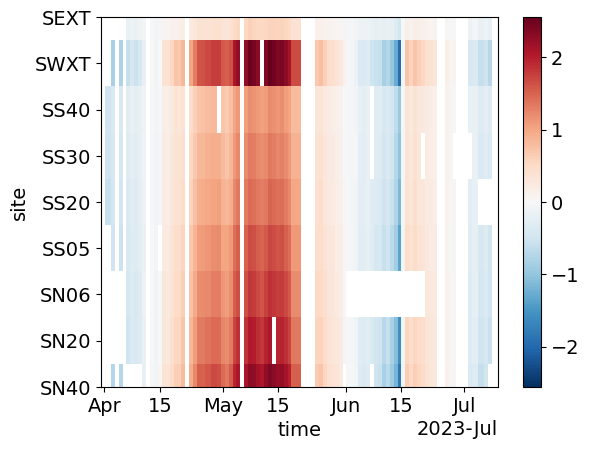

In [5]:
### calculate residual SSH

resid_ssh = swot.ssh_comparison - buoy.ssh
resid_ssh.plot()
plt.show()

resid_ssh_PIB = swot.ssh_comparison_PIB - buoy.ssh
resid_ssh_PIB.plot()
plt.show()

In [6]:
### calculate linear fit for PGC and PIB

linear_cor = np.ones((9, len(swot.swot_cycle)))*np.nan

for i in range(len(swot.swot_cycle)):
    # only use cycles with at least 7 out of 9 residual values
    if len(resid_ssh[:,i].values[~np.isnan(resid_ssh[:,i].values)])>6:

        x = swot.PGC_cross_track_distance[:,i]
        y = resid_ssh[:,i].values
        
        x = x[~np.isnan(y)]
        y = y[~np.isnan(y)]
        
        slope, intercept = np.polyfit(x, y, 1)
        y_fitted = slope * swot.PGC_cross_track_distance[:,i] + intercept
        linear_cor[:,i] = y_fitted
        tmp_resid = y - (slope * x + intercept)
        
    else:
        linear_cor[:,i] = np.ones((9))*np.nan
        
        
linear_cor_PIB = np.ones((9, len(swot.swot_cycle)))*np.nan

for i in range(len(swot.swot_cycle)):
    # only use cycles with at least 7 out of 9 residual values
    if len(resid_ssh_PIB[:,i].values[~np.isnan(resid_ssh_PIB[:,i].values)])>6:

        x = swot.PIB_cross_track_distance[:,i]
        y = resid_ssh_PIB[:,i].values
        
        x = x[~np.isnan(y)]
        y = y[~np.isnan(y)]
        
        slope, intercept = np.polyfit(x, y, 1)
        y_fitted = slope * swot.PIB_cross_track_distance[:,i] + intercept
        linear_cor_PIB[:,i] = y_fitted
        tmp_resid = y - (slope * x + intercept)
        
    else:
        linear_cor_PIB[:,i] = np.ones((9))*np.nan

In [7]:
### calculate plane fit

buoy_lon_lat_resid = np.array([[buoy.lon[0,:], buoy.lat[0,:], resid_ssh[0,:]],
          [buoy.lon[1,:], buoy.lat[1,:], resid_ssh[1,:]],
          [buoy.lon[2,:], buoy.lat[2,:], resid_ssh[2,:]],
          [buoy.lon[3,:], buoy.lat[3,:], resid_ssh[3,:]],
          [buoy.lon[4,:], buoy.lat[4,:], resid_ssh[4,:]],
          [buoy.lon[5,:], buoy.lat[5,:], resid_ssh[5,:]],
          [buoy.lon[6,:], buoy.lat[6,:], resid_ssh[6,:]],
          [buoy.lon[7,:], buoy.lat[7,:], resid_ssh[7,:]],
          [buoy.lon[8,:], buoy.lat[8,:], resid_ssh[8,:]]])

plane_height = np.ones((9, len(swot.swot_cycle)))*np.nan

for i in range(len(swot.swot_cycle)):
    buoy_points = buoy_lon_lat_resid[:,:,i]
    
    # only use cycles with at least 7 out of 9 residual values
    if len(resid_ssh[:,i].values[~np.isnan(resid_ssh[:,i].values)])>6:

        buoy_points = buoy_points[~np.isnan(buoy_points).any(axis=1)]
        points = buoy_points
        
        plane = Plane.best_fit(points)


        # extract plane heights at buoy locations to get correction
        
        X, Y, Z = plane.to_mesh()
        
        lon_plane = X.flatten()
        lat_plane = Y.flatten()
        plane_points = np.array([lon_plane, lat_plane]).T
        
        plane_heights = Z.flatten()
        heights_interp = griddata(plane_points, plane_heights, (buoy.lon[:,i].values, buoy.lat[:,i].values), method='linear')
        
        plane_height[:,i] = heights_interp

        plane_resid = resid_ssh[:,i].values - heights_interp
        
    else:
        plane_height[:,i] = np.ones((9))*np.nan

plane_cor = plane_height

In [8]:
### repeat for PIB

buoy_lon_lat_resid = np.array([[buoy.lon[0,:], buoy.lat[0,:], resid_ssh_PIB[0,:]],
          [buoy.lon[1,:], buoy.lat[1,:], resid_ssh_PIB[1,:]],
          [buoy.lon[2,:], buoy.lat[2,:], resid_ssh_PIB[2,:]],
          [buoy.lon[3,:], buoy.lat[3,:], resid_ssh_PIB[3,:]],
          [buoy.lon[4,:], buoy.lat[4,:], resid_ssh_PIB[4,:]],
          [buoy.lon[5,:], buoy.lat[5,:], resid_ssh_PIB[5,:]],
          [buoy.lon[6,:], buoy.lat[6,:], resid_ssh_PIB[6,:]],
          [buoy.lon[7,:], buoy.lat[7,:], resid_ssh_PIB[7,:]],
          [buoy.lon[8,:], buoy.lat[8,:], resid_ssh_PIB[8,:]]])

plane_height = np.ones((9, len(swot.swot_cycle)))*np.nan

for i in range(len(swot.swot_cycle)):
    buoy_points = buoy_lon_lat_resid[:,:,i]
    
    # only use cycles with at least 7 out of 9 residual values
    if len(resid_ssh_PIB[:,i].values[~np.isnan(resid_ssh_PIB[:,i].values)])>6:

        buoy_points = buoy_points[~np.isnan(buoy_points).any(axis=1)]
        points = buoy_points
        
        plane = Plane.best_fit(points)


        # extract plane heights at buoy locations to get correction
        
        X, Y, Z = plane.to_mesh()
        
        lon_plane = X.flatten()
        lat_plane = Y.flatten()
        plane_points = np.array([lon_plane, lat_plane]).T
        
        plane_heights = Z.flatten()
        heights_interp = griddata(plane_points, plane_heights, (buoy.lon[:,i].values, buoy.lat[:,i].values), method='linear')
        
        plane_height[:,i] = heights_interp

        plane_resid = resid_ssh[:,i].values - heights_interp
        
    else:
        plane_height[:,i] = np.ones((9))*np.nan

plane_cor_PIB = plane_height

In [9]:
### create xarray dataset and save

# Define the site names
sites = ['SN40', 'SN20', 'SN06', 'SS05', 'SS20', 'SS30', 'SS40', 'SWXT', 'SEXT']

gnss_xt_cor = xr.Dataset(
    {
        'linear_fit': (('site', 'time'), linear_cor),
        'plane_fit': (('site', 'time'), plane_cor),
        'linear_fit_PIB': (('site', 'time'), linear_cor_PIB),
        'plane_fit_PIB': (('site', 'time'), plane_cor_PIB)
    },
    coords={
        'time': swot.time.values,
        'site': sites,
    }
)

In [10]:
gnss_xt_cor.to_netcdf('GNSS_derived_xt_correction.nc')